In [1]:
import torch 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from cdft.dft1d import dft_core
from cdft.pcsaft_eos import pcsaft

device = torch.device('cuda')

pi = np.pi
kB = 1.380649e-23
NA = 6.02214076e23

In [2]:
m = torch.tensor([1.2383], dtype=torch.float64)
sigma = torch.tensor([3.3001], dtype=torch.float64) # A
epsilon = torch.tensor([89.41], dtype=torch.float64) # K
parameters = {'m':m, 'sigma':sigma, 'epsilon':epsilon}

In [4]:
T = 77.4
eos = pcsaft(parameters, T)
P0 = eos.vapor_pressure(1e5)
P = torch.hstack((torch.arange(1e-7,1e-6,0.5e-7,dtype=torch.float64),torch.arange(1e-6,1e-5,0.5e-6,dtype=torch.float64),
                 torch.arange(1e-5,1e-4,0.5e-5,dtype=torch.float64),torch.arange(1e-4,1e-3,0.5e-4,dtype=torch.float64),
                 torch.arange(1e-3,1e-2,0.5e-3,dtype=torch.float64), torch.arange(1e-2,1e-1,0.5e-2,dtype=torch.float64),
                 torch.arange(0.1,0.7,0.01,dtype=torch.float64), torch.arange(0.7,0.85,0.005,dtype=torch.float64),
                 torch.arange(0.85,0.9,0.003,dtype=torch.float64), torch.arange(0.9,0.93,0.002,dtype=torch.float64),
                 torch.arange(0.93,1.0,0.0015,dtype=torch.float64)))*P0

bulk_density = torch.empty_like(P)
composition = torch.tensor([1.0],dtype=torch.float64)

bulk_density[0] = eos.density(P[0],composition,'vap')
for i in range(1,len(P)):
    bulk_density[i] = eos.density(P[i],composition,bulk_density[i-1])

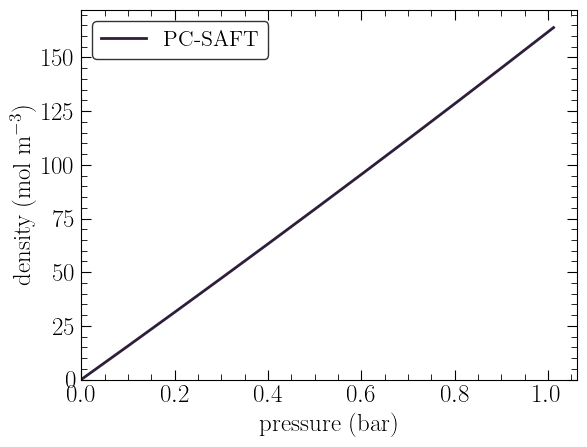

In [5]:
plt.rcParams.update({'text.usetex':True, 
'font.family':'serif'
})
colors = sns.color_palette("mako")

plt.plot(P*1e-5, bulk_density*1e30/(NA), '-', color=colors[0], linewidth=2.0, label='PC-SAFT')
plt.xlabel(r'pressure (bar)', fontsize=18)
plt.ylabel(r'density (mol m$^{-3}$)', fontsize=18)
plt.xlim([0.0,None])
plt.ylim([0.0,None])
plt.minorticks_on()
plt.tick_params(direction='in',right=True, top=True)
plt.tick_params(labelsize=18)
plt.tick_params(labelbottom=True, labeltop=False, labelright=False, labelleft=True)
# xticks = np.arange(0, 1e4,10)
# yticks = np.arange(0,16.1,4)
plt.tick_params(direction='in',which='minor', length=4, bottom=True, top=True, left=True, right=True)
plt.tick_params(direction='in',which='major', length=7, bottom=True, top=True, left=True, right=True)
# plt.xticks(xticks)
# plt.yticks(yticks)
plt.legend(fontsize=16, frameon=True, edgecolor='k')

In [6]:
data = pd.DataFrame()
data['P/P0'] = P.numpy()/P0

system_size = np.array([36.0])
cell_size = 1e-2

def steele(z,sigma,epsilon):
        rhos = 0.114
        Delta = 3.35
        return 2.0*pi*rhos*epsilon*sigma**2*Delta*(0.40*(sigma/z)**10-(sigma/z)**4-sigma**4/(3.0*Delta*(z+0.610*Delta)**3))

sigma_s = 3.40
epsilon_s = 28.0
sigma_is = 0.5*(sigma+sigma_s) 
epsilon_is = torch.sqrt(epsilon*epsilon_s)

dft = dft_core(parameters, T, system_size[0], cell_size, device)
Vext = np.zeros((dft.Nc,dft.points), dtype=np.float64)
for j in range(dft.Nc):
    Vext[j,0] = np.inf
    Vext[j,dft.points-1] = np.inf
    Vext[j,1:dft.points-1] = m[j]*(steele(dft.z[1:dft.points-1], sigma_is[j], epsilon_is[j]) \
        +steele(system_size[0]-dft.z[1:dft.points-1], sigma_is[j], epsilon_is[j]))

In [7]:
for k in range(len(system_size)):
 
    dft = dft_core(parameters, T, system_size[k], cell_size, device)

    Vext = np.zeros((dft.Nc,dft.points), dtype=np.float64)
    for j in range(dft.Nc):
        Vext[j,0] = np.inf
        Vext[j,dft.points-1] = np.inf
        Vext[j,1:dft.points-1] = m[j]*(steele(dft.z[1:dft.points-1], sigma_is[j], epsilon_is[j]) \
            +steele(system_size[k]-dft.z[1:dft.points-1], sigma_is[j], epsilon_is[j]))
        
    Nads = torch.empty_like(P)
    Ndes = torch.empty_like(P) 
    Omega_ads = torch.empty_like(P)
    Omega_des = torch.empty_like(P)

    dft.initial_condition(bulk_density[0],composition,Vext)

    for i in range(len(P)):
        dft.equilibrium_density_profile(bulk_density[i],composition,fmt='WB',
                                        solver='fire',alpha0=0.2,dt=0.01,tol=1e-6,logoutput=False)
        Nads[i] = (1e20/NA)*(dft.total_molecules[0]-bulk_density[i]*(system_size[k]-3.4))
        Omega_ads[i] = dft.Omega
        print(dft.it,dft.error.numpy(),system_size[k],P[i].numpy()/P0.numpy(),Nads[i].numpy())   
        if np.isnan(dft.error.numpy()): break

    Ndes[-1] = (1e20/NA)*(dft.total_molecules[0]-bulk_density[-1]*(system_size[k]-3.4))
    Omega_des[-1] = dft.Omega
    for i in range(len(P)-2,-1,-1):
        dft.equilibrium_density_profile(bulk_density[i],composition,fmt='WB',
                                        solver='fire',alpha0=0.2,dt=0.01,tol=1e-6,logoutput=False)
        Ndes[i] = (1e20/NA)*(dft.total_molecules[0]-bulk_density[i]*(system_size[k]-3.4))
        Omega_des[i] = dft.Omega
        print(dft.it,dft.error.numpy(),system_size[k],P[i].numpy()/P0.numpy(),Ndes[i].numpy())   
        if np.isnan(dft.error.numpy()): break

    # data[f'{Hin[k]*1e-1:.2f} nm'] = Nads.numpy()

188 7.473335280416848e-07 36.0 [1.e-07] 1.63724686368256e-09
125 9.515445770090365e-07 36.0 [1.5e-07] 2.456465072751469e-09
125 7.88592793321412e-07 36.0 [2.e-07] 3.2760831906951606e-09
125 7.010199018946405e-07 36.0 [2.5e-07] 4.09609983629613e-09
125 6.469340561325208e-07 36.0 [3.e-07] 4.916515428574718e-09
124 9.83928311781209e-07 36.0 [3.5e-07] 5.737328108032353e-09
124 9.43883688188373e-07 36.0 [4.e-07] 6.558542580598799e-09
124 9.143626053112603e-07 36.0 [4.5e-07] 7.380157199523685e-09
124 8.92040487025407e-07 36.0 [5.e-07] 8.202172364926996e-09
124 8.748410960683622e-07 36.0 [5.5e-07] 9.024588477037449e-09
124 8.614167944395622e-07 36.0 [6.e-07] 9.847405936316308e-09
124 8.508547257763918e-07 36.0 [6.5e-07] 1.0670625143609895e-08
124 8.425146563427578e-07 36.0 [7.e-07] 1.1494246500233842e-08
124 8.359344489539734e-07 36.0 [7.5e-07] 1.2318270408022446e-08
106 4.057127882421785e-07 36.0 [8.e-07] 1.3142703188762403e-08
106 3.784676383226215e-07 36.0 [8.5e-07] 1.3967534183162487e-08


In [8]:
Neq = np.copy(Nads)
Omega_eq = np.copy(Omega_ads)
for i in range(len(P)):
    if Omega_des[i] < Omega_ads[i]:
        Omega_eq[i] = Omega_des[i]
        Neq[i] = Ndes[i]

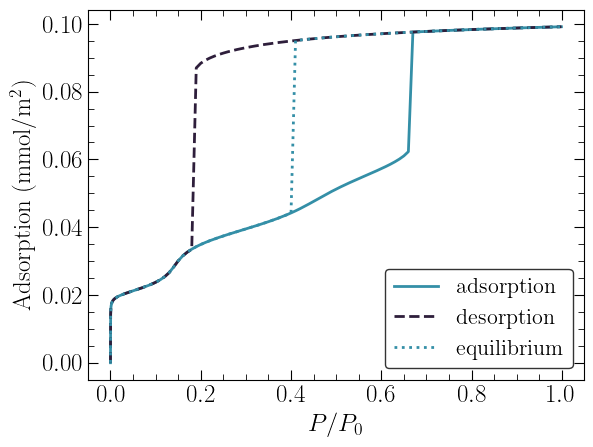

In [9]:
colors = sns.color_palette("mako")

plt.plot(P/P0, Nads*1e3, '-', color=colors[3], linewidth=2.0, label='adsorption')
plt.plot(P/P0, Ndes*1e3, '--', color=colors[0], linewidth=2.0, label='desorption')
plt.plot(P/P0, Neq*1e3, ':', color=colors[3], linewidth=2.0, label='equilibrium')
plt.xlabel(r'$P/P_0$', fontsize=18)
plt.ylabel(r'Adsorption (mmol/m$^2$)', fontsize=18)
# plt.xlim([0.0,0.4])
# plt.ylim([0.0,2000])
plt.minorticks_on()
plt.tick_params(direction='in',right=True, top=True)
plt.tick_params(labelsize=18)
plt.tick_params(labelbottom=True, labeltop=False, labelright=False, labelleft=True)
# xticks = np.arange(0, 1e4,10)
# yticks = np.arange(0,16.1,4)
plt.tick_params(direction='in',which='minor', length=4, bottom=True, top=True, left=True, right=True)
plt.tick_params(direction='in',which='major', length=7, bottom=True, top=True, left=True, right=True)
# plt.xticks(xticks)
# plt.yticks(yticks)
plt.legend(fontsize=16, frameon=True, edgecolor='k')

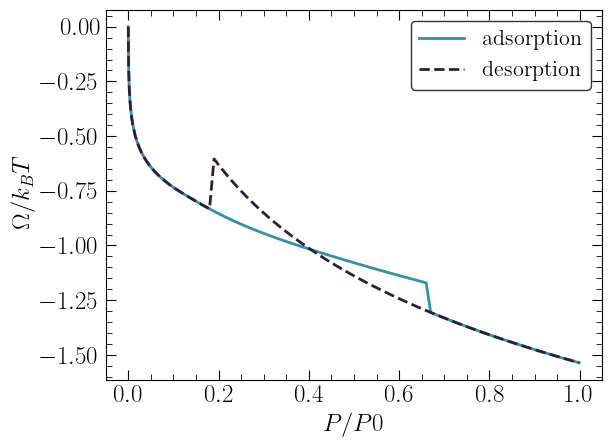

In [10]:
plt.plot(P/P0, Omega_ads, '-', color=colors[3], linewidth=2.0, label='adsorption')
plt.plot(P/P0, Omega_des, '--', color=colors[0], linewidth=2.0, label='desorption')
plt.xlabel(r'$P/P0$', fontsize=18)
plt.ylabel(r'$\Omega/k_B T$', fontsize=18)
# plt.xlim([0.0,5.0])
# plt.ylim([0.0,2000])
plt.minorticks_on()
plt.tick_params(direction='in',right=True, top=True)
plt.tick_params(labelsize=18)
plt.tick_params(labelbottom=True, labeltop=False, labelright=False, labelleft=True)
# xticks = np.arange(0, 1e4,10)
# yticks = np.arange(0,16.1,4)
plt.tick_params(direction='in',which='minor', length=4, bottom=True, top=True, left=True, right=True)
plt.tick_params(direction='in',which='major', length=7, bottom=True, top=True, left=True, right=True)
# plt.xticks(xticks)
# plt.yticks(yticks)
plt.legend(fontsize=16, frameon=True, edgecolor='k')